#  Four exercises for understanding echo and reberveration

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · June 2020 · 5 min read

---

## Summary 
Echoes are physical phenomenas produced by the repetive reflection of acoustic waves against the walls of a man-made or natural formation. This is what gives its acoustic properties to a room, captured in the so called [room-impulse response](https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Room_Acoustics/Room%20Impulse%20Response.ipynb), and allows your machine to perform a technique called [auralization](https://en.wikipedia.org/wiki/Auralization), to simulate the sound inside of a bathroom or a stadium. In this iPython notebook we will solve an exercise taken from the "Digital Signal Processing: Principles, Algorithms and Applications" book (by J. Proakis, D. Manolakis.) to understand the reberveration and echo formation and produce fun effects with regular recordings [1].

As a prelude, let's hear this version of the _O Come O Come Emmanuel_ where the echoes added by the Pantheon church beautifies Melinda Kathleen's voice:

In [2]:
from IPython.display import IFrame
IFrame('https://www.youtube.com/embed/IlNBnzyiomU', width=700, height=350)

# The three exercises

Let's begin presenting the exercises proposed by J. Proakis, D. Manolakis:

![](img/echoCancellation3.png)
![](img/echoCancellation4.png)

And now, let's go with their solution.

## Exercise (a)

To get the impulse response of exercise (a) we need to apply the inverse [Z transform](https://es.wikipedia.org/wiki/Transformada_Z) to the provided transfer function, which gives the following difference equation:

$$
y[n] = x[n] - \alpha y[n-D].
$$

To plot the impulse response, we can take an arbitrary support of 50 points and set the parameters to $\alpha=0.7$ and $D=5$:

Populating the interactive namespace from numpy and matplotlib


<StemContainer object of 3 artists>

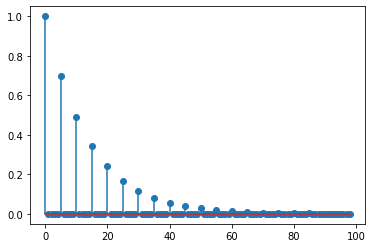

In [8]:
%pylab inline
import numpy as np

def comb(x, alpha, D):
    N = len(x)
    y = np.zeros(N)
    for n in range(0,N):
        y[n] = x[n] + alpha*(0 if n-D<0 else y[n-D]) # using positive gain for removal purposes
    return y
        
kronecker = np.zeros(99)
kronecker[0] = 1
    
pylab.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), use_line_collection=True)

We observe that, in effect, the impulse response of the comb filter is a function that decays exponentially (as we would expect from an echoe) because the repetitions get softer each time, not louder. We can process a random recording and hear the added effect. Let's take, for instance, this recording from a local catholic church:

In [9]:
from scipy.io import wavfile
from IPython.display import Audio

fs_wav, x_wav = wavfile.read('./wav/highquality_100520.wav')
distance = 100 # m
y = comb(x_wav, alpha=0.5, D=int((distance/380)*fs_wav))
Audio(y, rate=fs_wav) 

/usr/lib/python3/dist-packages/scipy/io/wavfile.py:272: WavFileWarning: Chunk (non-data) not understood, skipping it.
  warnings.warn("Chunk (non-data) not understood, skipping it.",


As you can hear, the recording contains echoes, which indicates that the comb filter is suitable for this task. We can even plot the absolute value of the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) to calculate the echo delay. As a matter of the fact, the echoes in the autocorrelation visualized as peaks in the graph.

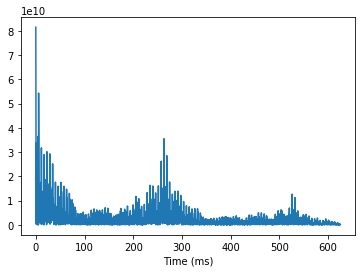

In [13]:
def plotAutocorr(x,fs):
    r = np.correlate(x,x,'same')
    r = r[int(len(r)/2):-1] # the correlation is simetric, so we can discard the first half
    t = 1000*np.linspace(0,(len(r)+0.0)/fs,len(r)) # plot in milliseconds
    pylab.plot(t,np.abs(r))
    pylab.xlabel('Time (ms)')
    
plotAutocorr(y[0:10000],fs_wav)

As we see above, the echo delay is approximately 270 ms.

## Exercise (b) 

On this exercise with got a new transfer function, so we proceed to repeat the same procedure of exercise (a). The difference equation is now:

$$
y[n] = -\alpha x[n] + x[n-D] + \alpha y[n-D],
$$

and by reusing the same parameters $\alpha$ and $D$, the impulse response would look like this:

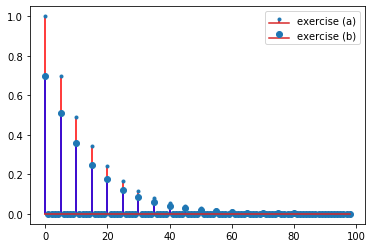

In [7]:
def allpasscomb(x, alpha, D):
    N = len(x)
    y = np.zeros(N)
    for n in range(0,N):
        y[n] = -alpha*x[n] + (0 if n-D<0 else x[n-D]) + alpha*(0 if n-D<0 else y[n-D])
    return y
        
pylab.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), linefmt='red', markerfmt='.', use_line_collection=True, label='exercise (a)')
pylab.stem(np.abs(allpasscomb(kronecker,alpha=0.7,D=5)), linefmt='blue', use_line_collection=True, label='exercise (b)')
pylab.legend()

The blue curve on the figure represents the new impulse response while the red one is the old one. We see that both are identical, except that the second one is shifted one unit to the left. Now, if we put multiple all pass filters in cascade and setup the parameters as in unit 1, the impulse response would look like this:

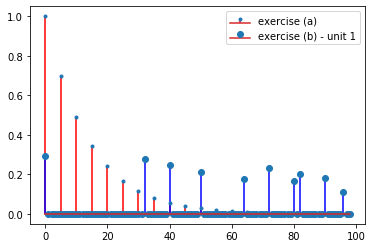

In [5]:
def cascade(x, alphas, Ds):
    y = x
    for i in range(0,len(alphas)):
        y = allpasscomb(y,alphas[i],Ds[i])
    return y

pylab.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), linefmt='red', markerfmt='.', use_line_collection=True, label='exercise (a)')
pylab.stem(np.abs(cascade(kronecker, [0.7,0.665,0.63175], [50,40,32])), linefmt='blue', use_line_collection=True, label='exercise (b) - unit 1')
pylab.legend()

We notice that the exponential decay shape has been lost and that the impulses are not aligned. Also, there is a region between 0 and 30 samples that is empty. How would it sound?

In [9]:
y = cascade(x_wav, [0.7,0.665,0.63175], np.multiply(100, [50,40,32])) # escalamos los retrasos para escucharlos
Audio(y, rate=fs_wav) 

As you can hear, the audio is completely a mess of repetitions and, at the end, the audio becomes incomprehensible. Now let's plot the impulse response with the parameters of unit 2:

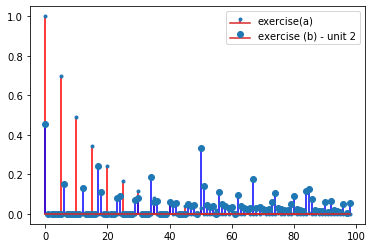

In [8]:
pylab.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), linefmt='red', markerfmt='.', use_line_collection=True, label='exercise(a)')
pylab.stem(np.abs(cascade(kronecker, [0.7,0.77,0.847], [50,17,6])), linefmt='blue', use_line_collection=True, label='exercise (b) - unit 2')
pylab.legend()

Uhm, now we observe that the impulses are better unaligned than unit 1 but the exponential shape is not always preserved. Once again, let's use to process the recording:

In [12]:
y = cascade(x_wav, [0.7,0.77,0.847], np.multiply(100, [50,17,6])) # escalamos los retrasos para escucharlos
Audio(y, rate=fs_wav) 

As you can hear, despite the audio does not have the same quality than exercise (a), it is clear enough almost to the end.

## Exercise (c)

At this point, we can answer the question in exercise (c). Unit 1 is a better reverberator because it doesn't produce clear repetitions of the signal, and this might be happening because the delays are long: 32 samples, which is the shortest delay in unit 1, corresponding to a delay in time of:

In [12]:
T_u1_min = (32.0/fs_wav)*1000;
T_u2_min = (6.0/fs_wav)*1000;
print('%.2f ms (unit 1) vs %.2f ms (unit 2)' % (T_u1_min, T_u2_min))

4.00 ms (unit 1) vs 0.75 ms (unit 2)


# One more exercise (not in the book)

The echo added by the transfer function of exercise (a) can be reverted using its inverse: $H^{-1}(z) = 1 - \alpha z^{-D}$, as explained by Prandoni et al. [2]. The respective difference function is $z[n] = y[n] - \alpha y[n-D]$.

In [16]:
def inverseComb(x, alpha, D):
    N = len(x)
    y = np.zeros(N)
    for n in range(0,N):
        y[n] = x[n] - alpha*(0 if n-D<0 else x[n-D])
    return y

z = inverseComb(y, alpha=0.5, D=int((distance/380)*fs_wav))
Audio(z, rate=fs_wav) 

As you can hear, the echoes have been removed completely. This method works because we had the transfer function by forehand, in the practice, echo is removed using [more advanced techniques](https://en.wikipedia.org/wiki/Echo_suppression_and_cancellation) for unknown transfer functions.

## References

1. J. Proakis, D. Manolakis. Digital Signal Processing: Principles, Algorithms and Applications, 3rd Edition. Peason.
2. P. Prandoni, M. Vetterli, I. Dokmanic. Lesson 4.12: Dereverberation and echo cancellation. Digital signal processing. LCAV-EPFL at Coursera. URL: https://www.coursera.org/learn/dsp